# PROJET : ALGORITHMIQUE DES GRAPHES 
**Auteurs :** Abdel DERRA Founeke et Ingrid DJALEU TCHOUAMOU  

---

## INTRODUCTION ET CONTEXTE
Ce projet vise à modéliser et analyser un réseau routier à l'aide de la **Théorie des Graphes**. Nous utilisons un graphe pondéré $G=(V, E, w)$ représentant une carte simplifiée de la France, où :
* **Les sommets ($V$)** sont des villes (Paris, Lyon, Marseille, etc.).
* **Les arêtes ($E$)** sont les routes reliant ces villes.
* **Les poids ($w$)** représentent les distances en kilomètres.

Le projet couvre l'ensemble du cycle de vie algorithmique : de la modélisation brute à l'optimisation avancée (PCC, ACPM) jusqu'à l'application industrielle (Ordonnancement PERT).

---

##  Import et chargement des données


In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# Configuration de l'affichage
%matplotlib inline

# Charge le graphe depuis un fichier JSON.
def load_graph(json_path):

    # 1. Vérification du fichier
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")
    
    # 2. Lecture du JSON
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 3. Initialisation du Graphe (Non-Orienté)
    G = nx.Graph()
    
    # 4. Ajout des sommets (V)
    if "nodes" in data:
        G.add_nodes_from(data["nodes"])
    
    # 5. Ajout des arêtes pondérées (E)
    if "edges" in data:
        for e in data["edges"]:
            # e["u"] = sommet 1, e["v"] = sommet 2, e["w"] = poids
            G.add_edge(e["u"], e["v"], weight=e["w"])
            
    return G

# --- EXÉCUTION ---
try:
    # Chargement du graphe
    G_projet = load_graph("graphe.json")
    print(" Chargement réussi : L'objet G_projet est créé.")
    
except Exception as e:
    print(f" Erreur critique : {e}")

 Chargement réussi : L'objet G_projet est créé.


## Visualisation du graphe de base


Génération de la vue du graphe...


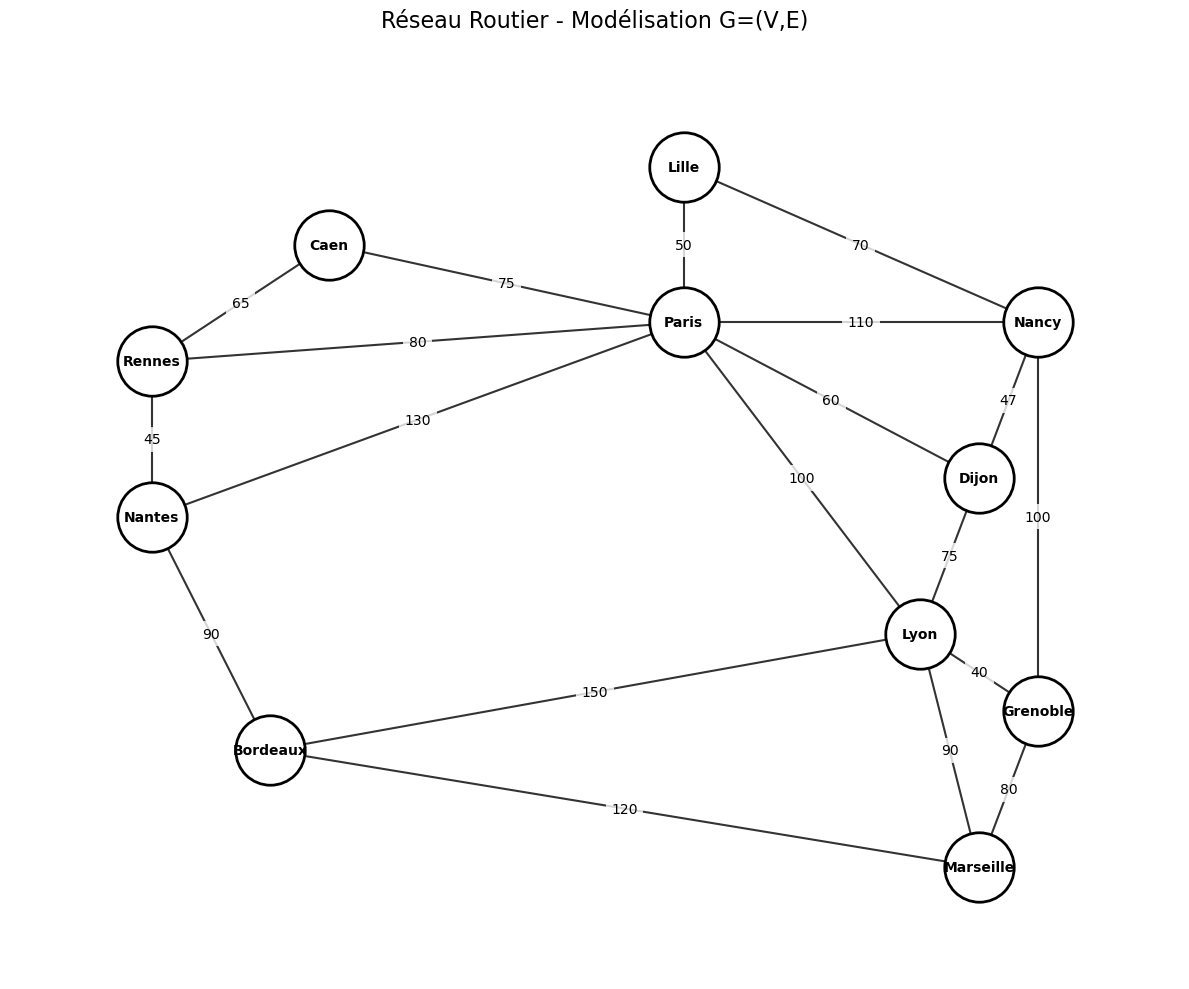

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

#Affiche le graphe de base
def dessiner_graphe(G):
    
    plt.figure(figsize=(12, 10)) # Grande taille pour la lisibilité
    
    # 1. DÉFINITION DU LAYOUT (POSITIONS)
    pos = {
        "Lille":      (55, 95),
        "Caen":       (25, 85),
        "Rennes":     (10, 70),
        "Brest":      (0, 75),  
        "Nantes":     (10, 50),
        "Bordeaux":   (20, 20),
        "Paris":      (55, 75),
        "Nancy":      (85, 75),
        "Dijon":      (80, 55),
        "Lyon":       (75, 35),
        "Grenoble":   (85, 25),
        "Marseille":  (80, 5),# Si ajouté plus tard
    }
    
    # Filtrer les positions pour ne garder que les villes présentes dans G
    # Cela évite une erreur si pos contient plus de villes que le graphe actuel
    pos_filtered = {k: v for k, v in pos.items() if k in G.nodes()}
    
    # Si des villes manquent dans 'pos', on utilise un layout spring pour celles-ci
    if len(pos_filtered) < len(G.nodes()):
        print("Note : Certaines villes n'ont pas de coordonnées fixes, ajustement automatique...")
        pos_filtered = nx.spring_layout(G, k=0.5, seed=42)

    # 2. DESSIN DES ARÊTES )
    nx.draw_networkx_edges(
        G, pos_filtered, 
        width=1.5, 
        edge_color='black', 
        alpha=0.8
    )
    
    # 3. DESSIN DES SOMMETS 
    # node_size=2500 assure que le texte tient dedans
    nx.draw_networkx_nodes(
        G, pos_filtered, 
        node_size=2500, 
        node_color='white', 
        edgecolors='black', 
        linewidths=2
    )
    
    # 4. DESSIN DES LABELS DE SOMMETS 
    nx.draw_networkx_labels(
        G, pos_filtered, 
        font_size=10, 
        font_weight='bold', 
        font_family='sans-serif'
    )
    
    # 5. DESSIN DES POIDS 
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos_filtered, 
        edge_labels=edge_labels, 
        font_size=10, 
        font_color='black', 
        rotate=False,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )
    
    # Finitions
    plt.title("Réseau Routier - Modélisation G=(V,E)", fontsize=16, pad=20)
    plt.axis('off') # Cache les axes X/Y
    plt.margins(0.1) # Marge de sécurité
    plt.tight_layout()
    plt.show()

# --- TEST DE VISUALISATION ---
if 'G_projet' in locals():
    print("Génération de la vue du graphe...")
    dessiner_graphe(G_projet)
else:
    print("Erreur : L'objet G_projet n'existe pas. Relancez l'Étape 1.")

## I — Parcours de graphe : BFS et DFS

In [3]:
import networkx as nx

def parcours_largeur(graphe, source):
    """
    Explore le graphe en utilisant l'algorithme de parcours en largeur (BFS).
    Returns:
        list: La liste des arêtes formant l'arbre de parcours BFS (Tree Edges).
        list: La liste ordonnée des sommets visités.
    """
    if source not in graphe:
        raise ValueError(f"La source '{source}' n'existe pas dans le graphe.")
        
    # Génération de l'arbre BFS
    bfs_tree = nx.bfs_tree(graphe, source)
    
    return list(bfs_tree.edges()), list(bfs_tree.nodes())

def parcours_profondeur(graphe, source):
    """
    Explore le graphe en utilisant l'algorithme de parcours en profondeur (DFS).
    Returns:
        list: La liste des arêtes formant l'arbre de parcours DFS.
        list: La liste ordonnée des sommets visités.
    """
    
    if source not in graphe:
        raise ValueError(f"La source '{source}' n'existe pas dans le graphe.")
        
    # Génération de l'arbre DFS
    dfs_tree = nx.dfs_tree(graphe, source)
    
    return list(dfs_tree.edges()), list(dfs_tree.nodes())

print(" Fonctions 'parcours_largeur' et 'parcours_profondeur' définies.")


 Fonctions 'parcours_largeur' et 'parcours_profondeur' définies.


###  Fonction de visualisation unifée pour les algorithmes


In [4]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph_clean(G, highlight_edges=None, highlight_nodes=None, title="", color_code='red'):
    """
    Fonction de visualisation pour les differents algorithmes.
    
    Args:
        G (nx.Graph): Le graphe complet.
        highlight_edges (list): Liste des arêtes à mettre en valeur [(u,v), ...].
        highlight_nodes (list): Liste des sommets à mettre en valeur [u, v, ...].
        title (str): Titre de la figure.
        color_code (str): Couleur des éléments mis en valeur.
    """
    plt.figure(figsize=(14, 9)) # Grande taille pour lisibilité maximale
    
    # 1. GESTION DU LAYOUT (POSITIONS)
    # Priorité absolue à la carte géographique si elle existe ('pos')
    if 'pos' in globals():
        layout = globals()['pos']
    else:
        # Sinon, layout aéré pour éviter les superpositions
        layout = nx.spring_layout(G, k=0.6, iterations=100, seed=42)

    # 2. DESSIN DE L'ARRIÈRE-PLAN (Graphe complet discret)
    # Arêtes en gris clair, fines
    nx.draw_networkx_edges(
        G, layout, 
        edge_color='lightgrey', 
        width=1.5, 
        alpha=0.6
    )
    # Sommets (base)
    nx.draw_networkx_nodes(
        G, layout, 
        node_color='white', 
        edgecolors='lightgrey', 
        node_size=2200
    )

    # 3. DESSIN DU PREMIER PLAN (Éléments mis en valeur)
    if highlight_edges:
        nx.draw_networkx_edges(
            G, layout, 
            edgelist=highlight_edges, 
            edge_color=color_code, 
            width=4, 
            alpha=0.9
        )
        
    if highlight_nodes:
        nx.draw_networkx_nodes(
            G, layout, 
            nodelist=highlight_nodes, 
            node_color='white', 
            edgecolors=color_code, 
            linewidths=3, 
            node_size=2200
        )

    # 4. ÉTIQUETTES ET TEXTE (Lisibilité optimisée)
    # Noms des villes
    nx.draw_networkx_labels(
        G, layout, 
        font_size=11, 
        font_weight='bold', 
        font_family='sans-serif'
    )
    
    # Poids des arêtes (avec fond blanc pour ne pas être barrés par les lignes)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, layout, 
        edge_labels=edge_labels, 
        font_size=9, 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

    plt.title(title, fontsize=18, pad=20)
    plt.axis('off') # Cadre épuré
    plt.tight_layout()
    plt.show()

print("Fonction de visualisation standardisée chargée.")

Fonction de visualisation standardisée chargée.


### Teste de Visualisation BFS et DFS

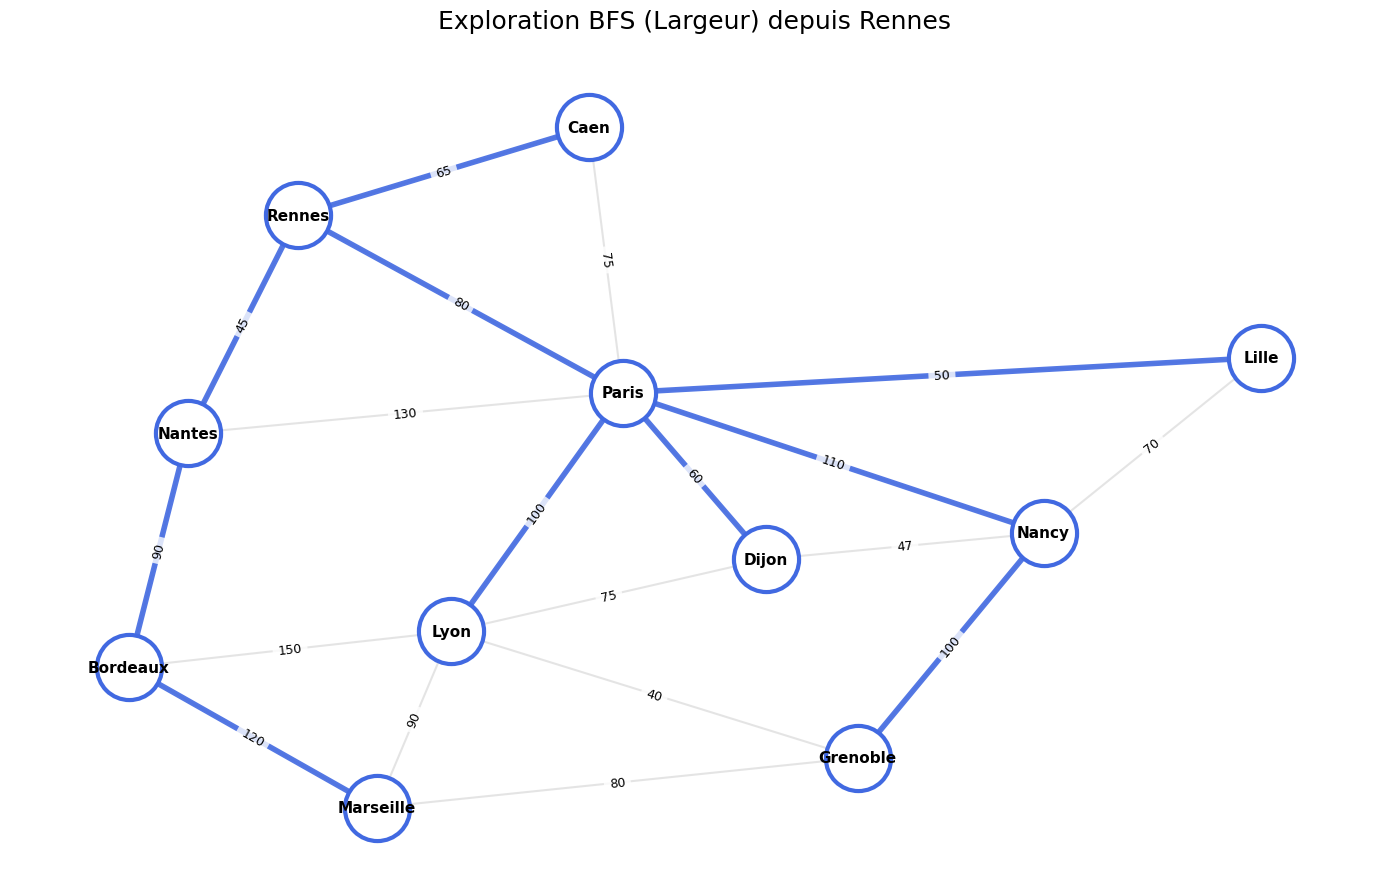

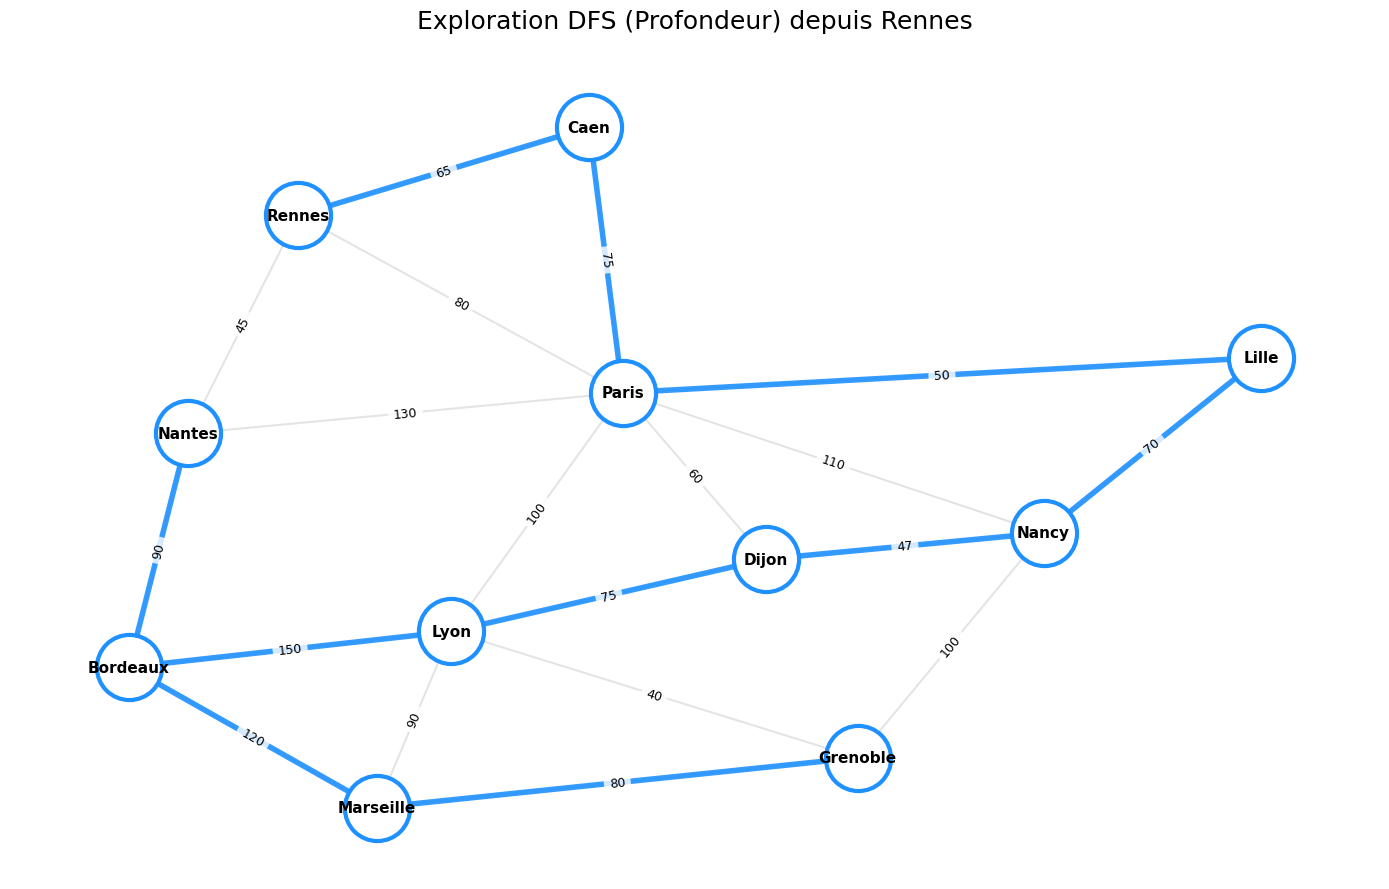

In [5]:
VILLE_DEPART = "Rennes"

if 'G_projet' in locals():
    # 1. BFS
    edges_bfs, nodes_bfs = parcours_largeur(G_projet, VILLE_DEPART)
    draw_graph_clean(
        G_projet, 
        highlight_edges=edges_bfs, 
        highlight_nodes=nodes_bfs,
        title=f"Exploration BFS (Largeur) depuis {VILLE_DEPART}", 
        color_code='#4169E1' # Royal Blue
    )
    
    # 2. DFS
    edges_dfs, nodes_dfs = parcours_profondeur(G_projet, VILLE_DEPART)
    draw_graph_clean(
        G_projet, 
        highlight_edges=edges_dfs, 
        highlight_nodes=nodes_dfs,
        title=f"Exploration DFS (Profondeur) depuis {VILLE_DEPART}", 
        color_code='#1E90FF' # Dodger Blue
    )

## II — Arbre couvrant de poids minimum : Prim et Kruskal

In [6]:
import networkx as nx
import heapq # Pour la file de priorité de Prim

# --- OUTIL : STRUCTURE UNION-FIND (Pour Kruskal) ---
class UnionFind:
    """
    Structure de données pour gérer les ensembles disjoints.
    Utilisée dans Kruskal pour détecter les cycles efficacement.
    """
    def __init__(self, elements):
        # Chaque élément est initialement son propre parent (ensemble singleton)
        self.parent = {e: e for e in elements}

    def find(self, item):
        # Trouve le représentant de l'ensemble (avec compression de chemin)
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, item1, item2):
        # Fusionne les deux ensembles
        root1 = self.find(item1)
        root2 = self.find(item2)
        if root1 != root2:
            self.parent[root1] = root2
            return True # Fusion réussie (pas de cycle)
        return False # Déjà dans le même ensemble (créerait un cycle)

# --- ALGORITHME 1 : PRIM ---
def prim(graphe, source):
    """
    Implémente l'algorithme de Prim pour trouver l'ACPM.
    Principe : Construction progressive de l'arbre en ajoutant toujours
    le voisin le plus proche de la composante connexe actuelle.
    
    Returns:
        nx.Graph: L'arbre couvrant résultant.
        int: Le poids total de l'arbre.
    """
    if source not in graphe:
        raise ValueError(f"Source '{source}' introuvable.")
        
    mst = nx.Graph() # L'arbre résultat
    visites = {source} # Ensemble des sommets déjà dans l'arbre
    
    # File de priorité : (poids, u, v)
    # Contient les arêtes frontalières (reliant l'arbre au reste du graphe)
    frontiere = []
    
    # Initialisation avec les voisins de la source
    for voisin, data in graphe[source].items():
        heapq.heappush(frontiere, (data['weight'], source, voisin))
        
    poids_total = 0
    
    # Boucle gloutonne
    while frontiere:
        poids, u, v = heapq.heappop(frontiere) # On prend l'arête la moins chère
        
        if v not in visites:
            # Si v est nouveau, on l'ajoute à l'arbre
            visites.add(v)
            mst.add_edge(u, v, weight=poids)
            poids_total += poids
            
            # On ajoute les nouvelles arêtes partant de v à la frontière
            for voisin_de_v, data_v in graphe[v].items():
                if voisin_de_v not in visites:
                    heapq.heappush(frontiere, (data_v['weight'], v, voisin_de_v))
                    
    return mst, poids_total

# --- ALGORITHME 2 : KRUSKAL ---
def kruskal(graphe):
    """
    Implémente l'algorithme de Kruskal.
    Principe : Tri des arêtes par poids croissant et sélection si elles
    ne créent pas de cycle.
    """
    mst = nx.Graph()
    mst.add_nodes_from(graphe.nodes()) # L'arbre contient tous les sommets
    
    uf = UnionFind(graphe.nodes())
    poids_total = 0
    
    # 1. Récupération et Tri des arêtes par poids croissant
    # Format : (u, v, poids)
    aretes = []
    for u, v, data in graphe.edges(data=True):
        aretes.append((u, v, data['weight']))
    
    # Tri stable par poids (clé = x[2])
    aretes_triees = sorted(aretes, key=lambda x: x[2])
    
    # 2. Itération et Sélection
    for u, v, w in aretes_triees:
        # Si u et v sont dans des composantes différentes
        if uf.union(u, v):
            mst.add_edge(u, v, weight=w)
            poids_total += w
            
    return mst, poids_total

print(" Algorithmes Prim et Kruskal chargés.")

 Algorithmes Prim et Kruskal chargés.


### Teste de visualisation Prim 

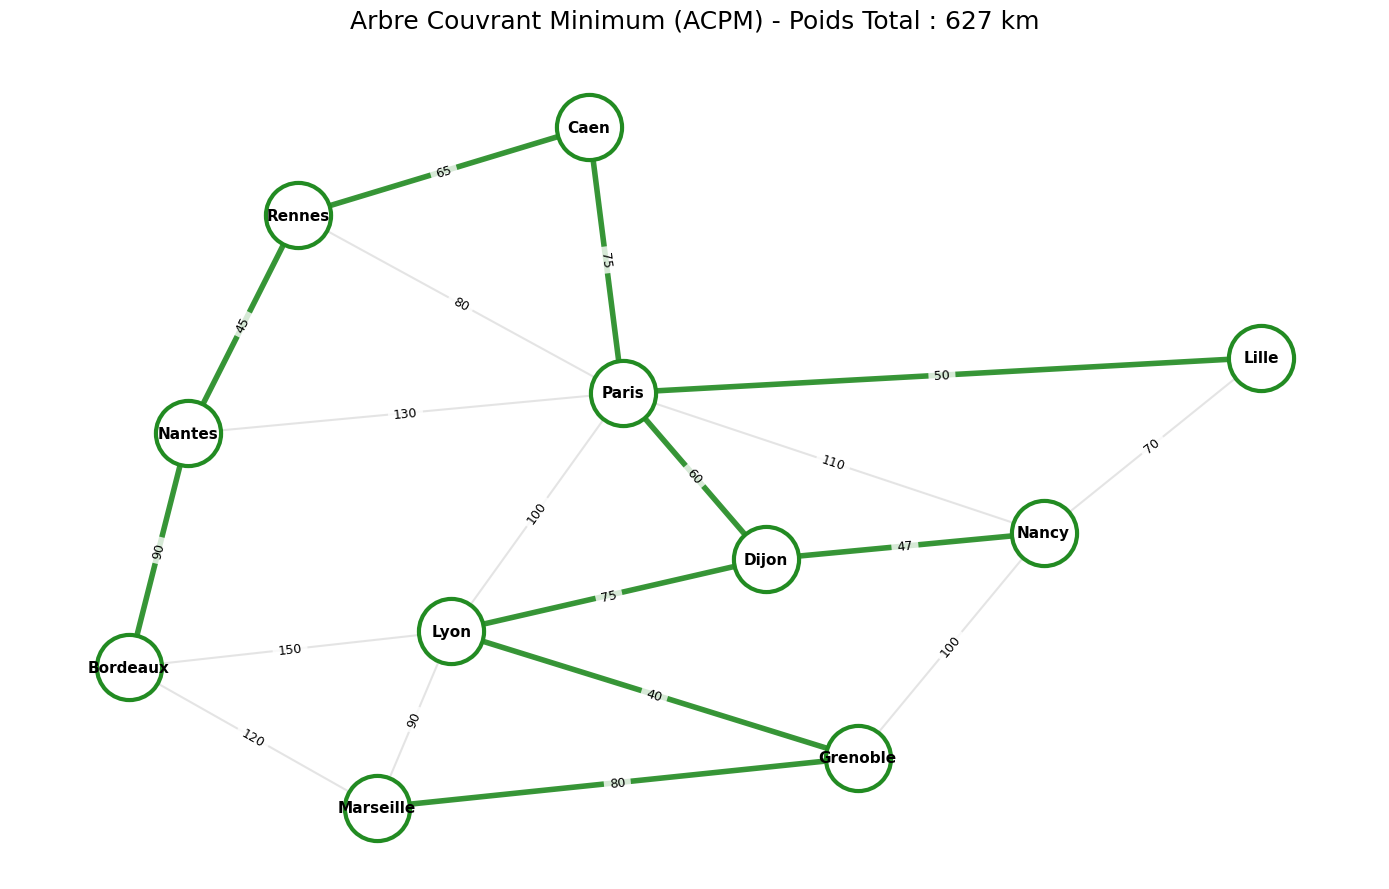

In [7]:
# Note : Kruskal donne le même résultat visuel, on affiche Prim.

if 'G_projet' in locals():
    # Recalcul (au cas où)
    mst_prim, poids_prim = prim(G_projet, source="Rennes")
    
    draw_graph_clean(
        G_projet, 
        highlight_edges=list(mst_prim.edges()), 
        highlight_nodes=list(mst_prim.nodes()),
        title=f"Arbre Couvrant Minimum (ACPM) - Poids Total : {poids_prim} km", 
        color_code='#228B22' # Forest Green
    )

## III — Plus court chemin : algorithme de Dijkstra

In [8]:
import heapq
import networkx as nx

def dijkstra(graphe, ville_depart, ville_arrivee):
    """
    Calcule le Plus Court Chemin entre deux villes via l'algorithme de Dijkstra.
        
    Returns:
        list: La liste ordonnée des villes constituant le chemin optimal.
        int: La distance totale du chemin.
    """
    # 1. Vérification des entrées
    if ville_depart not in graphe or ville_arrivee not in graphe:
        raise ValueError(f"Erreur : '{ville_depart}' ou '{ville_arrivee}' n'est pas dans le graphe.")
    
    # 2. Initialisation
    # Distances : d[v] = infini pour tout v, sauf d[start] = 0
    distances = {node: float('infinity') for node in graphe.nodes()}
    distances[ville_depart] = 0
    
    # Prédécesseurs : Pour reconstruire le chemin à la fin (père[v] = u)
    predecesseurs = {node: None for node in graphe.nodes()}
    
    # File de priorité (Min-Heap) : Stocke des tuples (distance_actuelle, ville)
    # On commence par la source avec une distance de 0
    file_priorite = [(0, ville_depart)]
    
    # 3. Boucle Gloutonne
    while file_priorite:
        # Extraction du sommet u ayant la plus petite distance provisoire
        dist_u, u = heapq.heappop(file_priorite)
        
        # Optimisation : Si on a déjà trouvé un chemin plus court vers u, on ignore
        if dist_u > distances[u]:
            continue
        
        # Arrêt anticipé : Si on a atteint la destination, on peut s'arrêter (optionnel mais efficace)
        if u == ville_arrivee:
            break
            
        # Relâchement des arêtes (Relaxation)
        # Pour chaque voisin v de u avec un poids w
        for v, attributes in graphe[u].items():
            poids = attributes['weight']
            distance_alternative = dist_u + poids
            
            # Si passer par u est plus court que le chemin connu vers v
            if distance_alternative < distances[v]:
                distances[v] = distance_alternative
                predecesseurs[v] = u
                heapq.heappush(file_priorite, (distance_alternative, v))
    
    # 4. Reconstruction du chemin (Backtracking)
    chemin = []
    courant = ville_arrivee
    
    # On remonte de l'arrivée vers le départ via les prédécesseurs
    while courant is not None:
        chemin.append(courant)
        courant = predecesseurs[courant]
        
    chemin.reverse() # On remet dans l'ordre Départ -> Arrivée
    
    # Vérification si le chemin existe (si la liste ne contient que l'arrivée et qu'elle n'est pas le départ)
    if chemin[0] != ville_depart:
        return [], float('infinity') # Pas de chemin possible
        
    return chemin, distances[ville_arrivee]

print(" Algorithme Dijkstra chargé.")

 Algorithme Dijkstra chargé.


### Teste de Visualisation Dijktra

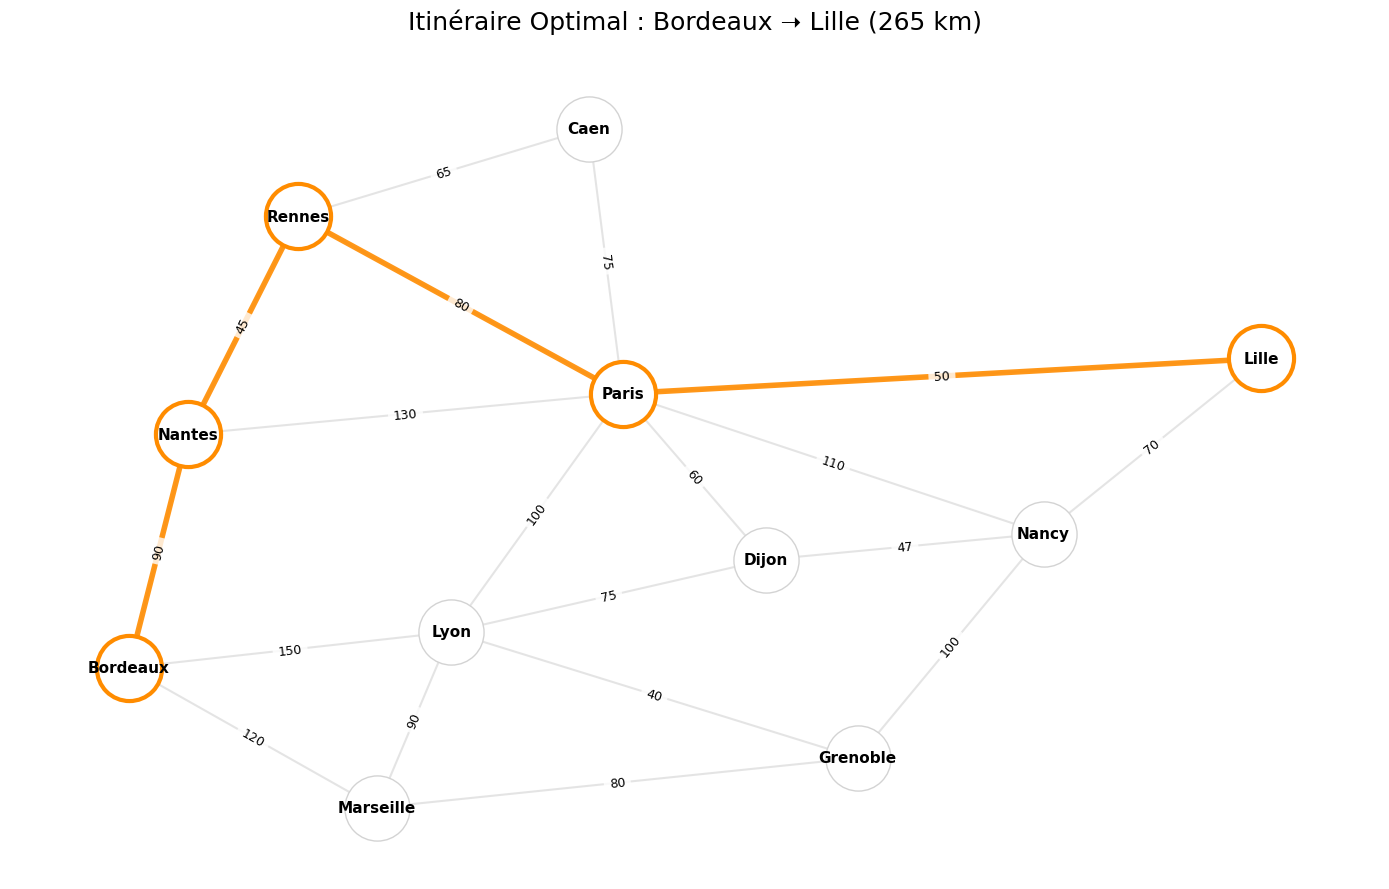

In [9]:
DEPART = "Bordeaux"
ARRIVEE = "Lille"

if 'G_projet' in locals():
    # Recalcul
    path, dist = dijkstra(G_projet, DEPART, ARRIVEE)
    
    if dist != float('infinity'):
        # Conversion du chemin (liste de noeuds) en liste d'arêtes pour le dessin
        # Ex: [A, B, C] -> [(A,B), (B,C)]
        edges_path = list(zip(path, path[1:]))
        
        draw_graph_clean(
            G_projet, 
            highlight_edges=edges_path, 
            highlight_nodes=path,
            title=f"Itinéraire Optimal : {DEPART} ➝ {ARRIVEE} ({dist} km)", 
            color_code='#FF8C00' # Dark Orange
        )

## IV — Plus courts chemins avancés :

### A — Bellman–Ford

In [10]:
import networkx as nx

def bellman_ford_path(graphe, source):
    """  
    Returns:
        tuple: (distances, predecesseurs, cycle_negatif_detecte)
    """
    # 1. Initialisation
    distances = {node: float('infinity') for node in graphe.nodes()}
    predecesseurs = {node: None for node in graphe.nodes()}
    distances[source] = 0
    nombre_sommets = len(graphe.nodes())
    
    # 2. Relâchement (Relaxation)
    for _ in range(nombre_sommets - 1):
        changement = False
        for u, v, data in graphe.edges(data=True):
            poids = data['weight']
            if distances[u] + poids < distances[v]:
                distances[v] = distances[u] + poids
                predecesseurs[v] = u
                changement = True
        if not changement:
            break
            
    # 3. Détection de Cycle Négatif
    cycle_negatif = False
    for u, v, data in graphe.edges(data=True):
        if distances[u] + data['weight'] < distances[v]:
            cycle_negatif = True
            break
            
    return distances, predecesseurs, cycle_negatif

def reconstruire_chemin(predecesseurs, source, destination):
    #Reconstruit la liste des villes du chemin optimal.
    path = []
    curr = destination
    
    # Remontée depuis la destination
    while curr is not None:
        path.append(curr)
        if curr == source:
            break
        curr = predecesseurs[curr]
        
    # Vérification : si on n'a pas atteint la source, il n'y a pas de chemin
    if path[-1] != source:
        return []
        
    return path[::-1] # Inversion pour avoir l'ordre Départ -> Arrivée

print(" Bellman-Ford chargé.")

 Bellman-Ford chargé.


#### Démontration Bellman-ford


MODIFICATION DU GRAPHE (Poids Négatifs) :
   ➜ Arête Rennes -> Nantes mise à -2 km (Gain de temps/carburant)
   ➜ Arête Lyon -> Marseille mise à -5 km (Gain de temps/carburant)

 RÉSULTATS DEPUIS Rennes :
 Stabilité : Pas de cycle négatif détecté.
 PCC vers Marseille : Rennes -> Paris -> Lyon -> Marseille
 Distance Cumulée : 175 (Notez l'impact des poids négatifs)



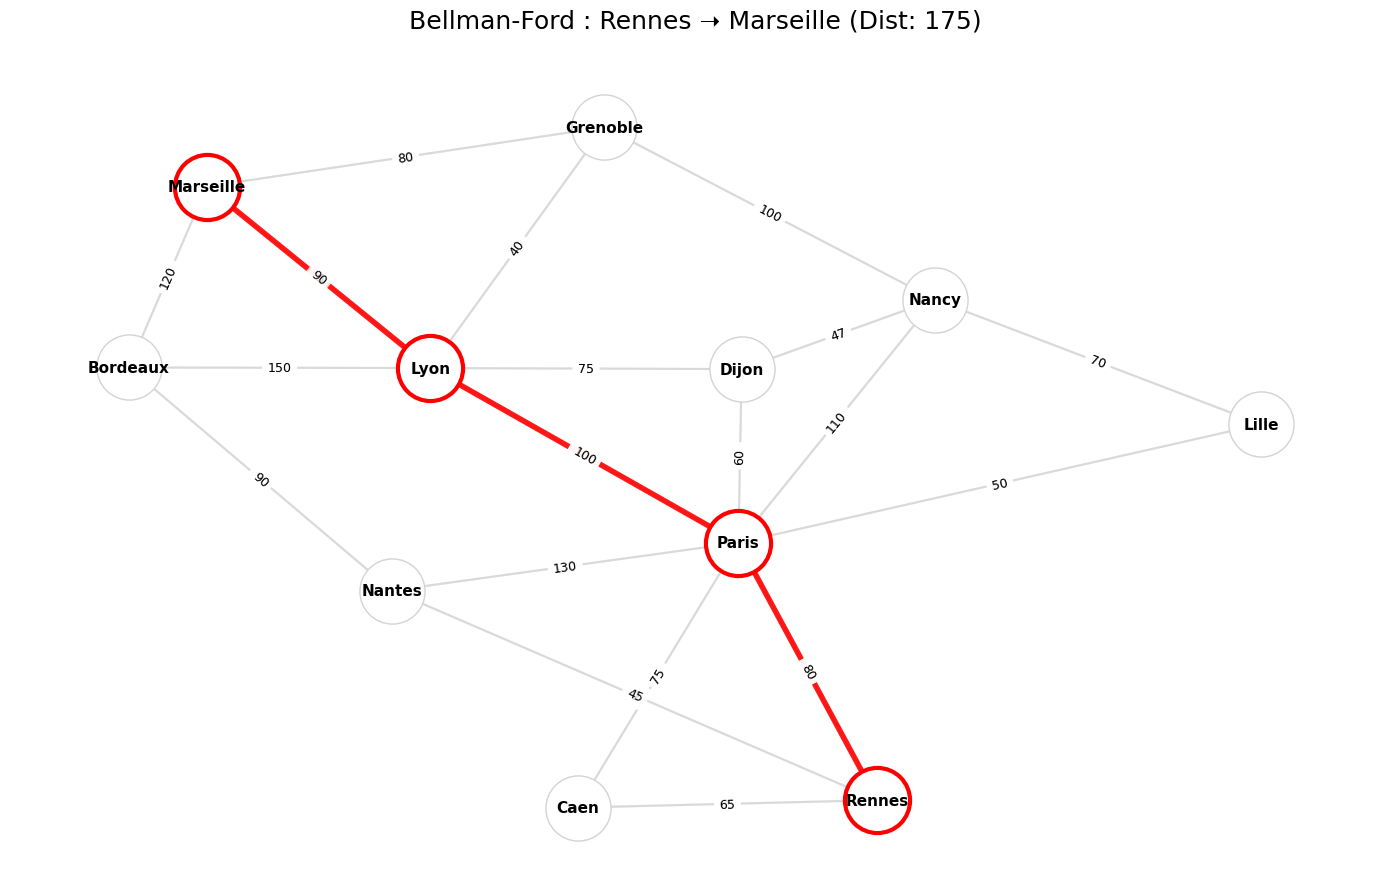

In [11]:
import matplotlib.pyplot as plt

# 1. PRÉPARATION DU GRAPHE SPÉCIFIQUE
# Conversion en orienté pour éviter les cycles immédiats avec poids négatifs
G_bellman = G_projet.to_directed()

# Ajout de poids négatifs (Scénario : "Vents favorables" ou "Autoroute Express")
# On modifie Rennes->Nantes et Lyon->Marseille
print("MODIFICATION DU GRAPHE (Poids Négatifs) :")
updates = [
    ("Rennes", "Nantes", -2),
    ("Lyon", "Marseille", -5)
]

for u, v, w in updates:
    if G_bellman.has_edge(u, v):
        G_bellman[u][v]['weight'] = w
        print(f"   ➜ Arête {u} -> {v} mise à {w} km (Gain de temps/carburant)")

# 2. CALCUL (Bellman-Ford)
SOURCE = "Rennes"
DESTINATION = "Marseille"

dist, preds, has_cycle = bellman_ford_path(G_bellman, SOURCE)

# 3. ANALYSE ET AFFICHAGE
print(f"\n RÉSULTATS DEPUIS {SOURCE} :")

if has_cycle:
    print("ALERTE : Un cycle de poids négatif a été détecté ! Les résultats sont instables.")
else:
    print(" Stabilité : Pas de cycle négatif détecté.")
    
    # Extraction du chemin vers la destination
    chemin_optimal = reconstruire_chemin(preds, SOURCE, DESTINATION)
    distance_finale = dist[DESTINATION]
    
    if chemin_optimal:
        print(f" PCC vers {DESTINATION} : {' -> '.join(chemin_optimal)}")
        print(f" Distance Cumulée : {distance_finale} (Notez l'impact des poids négatifs)")
        
        # 4. VISUALISATION AVANCÉE
        # Étape A : On dessine le chemin optimal en ROUGE avec notre fonction standard
        # On prépare la liste d'arêtes du chemin
        edges_path = list(zip(chemin_optimal, chemin_optimal[1:]))
        
        # On utilise draw_graph_clean pour faire le gros du travail (Fond + Chemin Rouge)
        print()
        draw_graph_clean(
            G_bellman, 
            highlight_edges=edges_path, 
            highlight_nodes=chemin_optimal,
            title=f"Bellman-Ford : {SOURCE} ➝ {DESTINATION} (Dist: {distance_finale})", 
            color_code='#FF0000' # Rouge
        )
        
        
    else:
        print(f" Aucun chemin trouvé entre {SOURCE} et {DESTINATION}.")

### B — Floyd–Warshall

In [12]:
import pandas as pd
import numpy as np

def floyd_warshall(graphe):
    """
    Calcule la matrice des plus courts chemins entre toutes les paires de sommets.
    """
    nodes = list(graphe.nodes())
    n = len(nodes)
    
    # 1. Initialisation de la matrice avec l'infini
    # On utilise un DataFrame pour gérer les labels (noms des villes) facilement
    inf = float('infinity')
    dist_matrix = pd.DataFrame(inf, index=nodes, columns=nodes)
    
    # Diagonale à 0
    for node in nodes:
        dist_matrix.at[node, node] = 0
        
    # Initialisation avec les poids des arêtes existantes
    for u, v, data in graphe.edges(data=True):
        dist_matrix.at[u, v] = data['weight']
        # Si le graphe est non-orienté, on remplit l'autre sens
        if not graphe.is_directed():
            dist_matrix.at[v, u] = data['weight']
            
    # 2. Triple Boucle (Coeur de l'algorithme)
    # k = sommet intermédiaire, i = origine, j = destination
    for k in nodes:
        for i in nodes:
            for j in nodes:
                # Si passer par k est plus court
                d_ik = dist_matrix.at[i, k]
                d_kj = dist_matrix.at[k, j]
                
                if d_ik + d_kj < dist_matrix.at[i, j]:
                    dist_matrix.at[i, j] = d_ik + d_kj
                    
    return dist_matrix

def analyser_centralite(matrice_distances):
    """
    Détermine la ville la plus centrale (celle qui a la distance moyenne minimale vers les autres).
    """
    # On remplace l'infini par NaN pour ne pas fausser la moyenne (si graphe non connexe)
    mat_clean = matrice_distances.replace(float('inf'), np.nan)
    
    # Calcul de la moyenne par ligne (axis=1)
    moyennes = mat_clean.mean(axis=1)
    
    ville_centrale = moyennes.idxmin()
    score = moyennes.min()
    
    return ville_centrale, score, moyennes

print(" Algorithme Floyd-Warshall chargé.")

 Algorithme Floyd-Warshall chargé.


#### Démonstration Floy-Warshall

 MATRICE DES DISTANCES (Floyd-Warshall)



,Paris,Lille,Rennes,Caen,Nantes,Bordeaux,Lyon,Dijon,Nancy,Grenoble,Marseille
Paris,0.0,50.0,80.0,75.0,125.0,215.0,100.0,60.0,107.0,140.0,190.0
Lille,50.0,0.0,130.0,125.0,175.0,265.0,150.0,110.0,70.0,170.0,240.0
Rennes,80.0,130.0,0.0,65.0,45.0,135.0,180.0,140.0,187.0,220.0,255.0
Caen,75.0,125.0,65.0,0.0,110.0,200.0,175.0,135.0,182.0,215.0,265.0
Nantes,125.0,175.0,45.0,110.0,0.0,90.0,225.0,185.0,232.0,265.0,210.0
Bordeaux,215.0,265.0,135.0,200.0,90.0,0.0,150.0,225.0,272.0,190.0,120.0
Lyon,100.0,150.0,180.0,175.0,225.0,150.0,0.0,75.0,122.0,40.0,90.0
Dijon,60.0,110.0,140.0,135.0,185.0,225.0,75.0,0.0,47.0,115.0,165.0
Nancy,107.0,70.0,187.0,182.0,232.0,272.0,122.0,47.0,0.0,100.0,180.0
Grenoble,140.0,170.0,220.0,215.0,265.0,190.0,40.0,115.0,100.0,0.0,80.0



 ANALYSE DE CENTRALITÉ :
   La ville la plus centrale est : **PARIS**
   Distance moyenne vers les autres villes : 103.82 km



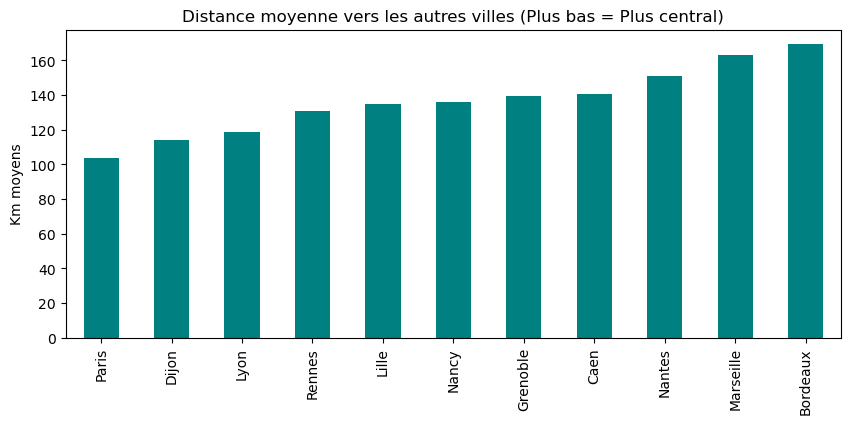

In [13]:

print(" MATRICE DES DISTANCES (Floyd-Warshall)")

# 1. Calcul (sur le graphe original G_projet pour avoir des distances réelles positives)
matrice_fw = floyd_warshall(G_projet)

# 2. Affichage Propre (Pandas)
# On arrondit pour la lisibilité
print()
display(matrice_fw) 

# 3. Analyse de Centralité
ville_top, score_top, toutes_moyennes = analyser_centralite(matrice_fw)

print("\n ANALYSE DE CENTRALITÉ :")
print(f"   La ville la plus centrale est : **{ville_top.upper()}**")
print(f"   Distance moyenne vers les autres villes : {score_top:.2f} km")

# Petit graphique pour comparer la centralité
print()
plt.figure(figsize=(10, 4))
toutes_moyennes.sort_values().plot(kind='bar', color='teal')
plt.title("Distance moyenne vers les autres villes (Plus bas = Plus central)")
plt.ylabel("Km moyens")
plt.show()

## V — Ordonnancement d’un projet : méthode PERT

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

class PERTManager:
    def __init__(self, projet_data):
        self.taches = projet_data
        self.G = nx.DiGraph()
        self.dates_tot = {}
        self.dates_tard = {}
        self.marges = {}
        self.chemin_critique = []
        self.duree_totale = 0
        
    def construire_graphe(self):
        """
        Construit le graphe PERT 
        Ici, les noeuds sont les étapes (Début -> Fin) et les arêtes sont les tâches.
        """
        # Pour simplifier l'implémentation PERT standard :
        # On va utiliser une approche "Activity on Node" pour le calcul topologique
        # puis on le traduira pour l'affichage.
        
        # Ajout des noeuds tâches
        for tache, details in self.taches.items():
            self.G.add_node(tache, duration=details['duree'])
            
        # Ajout des arêtes de dépendance
        for tache, details in self.taches.items():
            for pred in details['predecesseurs']:
                self.G.add_edge(pred, tache)
                
    def calculer_dates(self):
        # 1. Tri Topologique (Ordre d'exécution)
        try:
            ordre_topo = list(nx.topological_sort(self.G))
        except nx.NetworkXUnfeasible:
            raise ValueError("Erreur : Le projet contient un cycle (boucle infinie) !")

        # 2. Calcul des Dates au Plus Tôt (Forward Pass)
        # ES (Early Start) / EF (Early Finish)
        earliest_start = {t: 0 for t in self.taches}
        earliest_finish = {t: 0 for t in self.taches}
        
        for tache in ordre_topo:
            # Le début au plus tôt est le max des fins au plus tôt des prédécesseurs
            preds = list(self.G.predecessors(tache))
            if preds:
                earliest_start[tache] = max(earliest_finish[p] for p in preds)
            else:
                earliest_start[tache] = 0
            
            earliest_finish[tache] = earliest_start[tache] + self.taches[tache]['duree']

        self.duree_totale = max(earliest_finish.values())
        self.dates_tot = earliest_start

        # 3. Calcul des Dates au Plus Tard (Backward Pass)
        # LS (Late Start) / LF (Late Finish)
        latest_finish = {t: self.duree_totale for t in self.taches}
        latest_start = {t: 0 for t in self.taches}
        
        for tache in reversed(ordre_topo):
            succs = list(self.G.successors(tache))
            if succs:
                latest_finish[tache] = min(latest_start[s] for s in succs)
            else:
                latest_finish[tache] = self.duree_totale
                
            latest_start[tache] = latest_finish[tache] - self.taches[tache]['duree']
            
        self.dates_tard = latest_start
        
        # 4. Calcul des Marges et Chemin Critique
        for t in self.taches:
            self.marges[t] = latest_start[t] - earliest_start[t]
            if self.marges[t] == 0:
                self.chemin_critique.append(t)
                
        return pd.DataFrame({
            "Durée": [self.taches[t]['duree'] for t in self.taches],
            "Début Tôt": [self.dates_tot[t] for t in self.taches],
            "Début Tard": [self.dates_tard[t] for t in self.taches],
            "Marge Totale": [self.marges[t] for t in self.taches],
            "Critique": ["OUI" if m == 0 else "NON" for m in self.marges.values()]
        }, index=self.taches.keys())

print(" Module PERT chargé.")

 Module PERT chargé.


###  DÉFINITION DU PROJET 


In [15]:

# Projet : DÉPLOIEMENT DE BORNES DE RECHARGE
projet_bornes = {
    "A": {"duree": 2,  "predecesseurs": [],      "desc": "Étude de faisabilité"},
    "B": {"duree": 5,  "predecesseurs": ["A"],   "desc": "Obtention permis"},
    "C": {"duree": 3,  "predecesseurs": ["A"],   "desc": "Commande matériel"},
    "D": {"duree": 4,  "predecesseurs": ["B"],   "desc": "Génie civil (Tranchées)"},
    "E": {"duree": 2,  "predecesseurs": ["C"],   "desc": "Livraison bornes"},
    "F": {"duree": 3,  "predecesseurs": ["D", "E"], "desc": "Installation électrique"},
    "G": {"duree": 1,  "predecesseurs": ["F"],   "desc": "Tests et Mise en service"}
}

# Initialisation
pert = PERTManager(projet_bornes)
pert.construire_graphe()
df_resultats = pert.calculer_dates()

print(f" Durée Totale du Projet : {pert.duree_totale} jours")
print("   Tâches Critiques (Marge = 0) :", pert.chemin_critique)
print()
display(df_resultats)

 Durée Totale du Projet : 15 jours
   Tâches Critiques (Marge = 0) : ['A', 'B', 'D', 'F', 'G']



,Durée,Début Tôt,Début Tard,Marge Totale,Critique
A,2,0,0,0,OUI
B,5,2,2,0,OUI
C,3,2,6,4,NON
D,4,7,7,0,OUI
E,2,5,9,4,NON
F,3,11,11,0,OUI
G,1,14,14,0,OUI


### VISUALISATION GRAPHE PERT


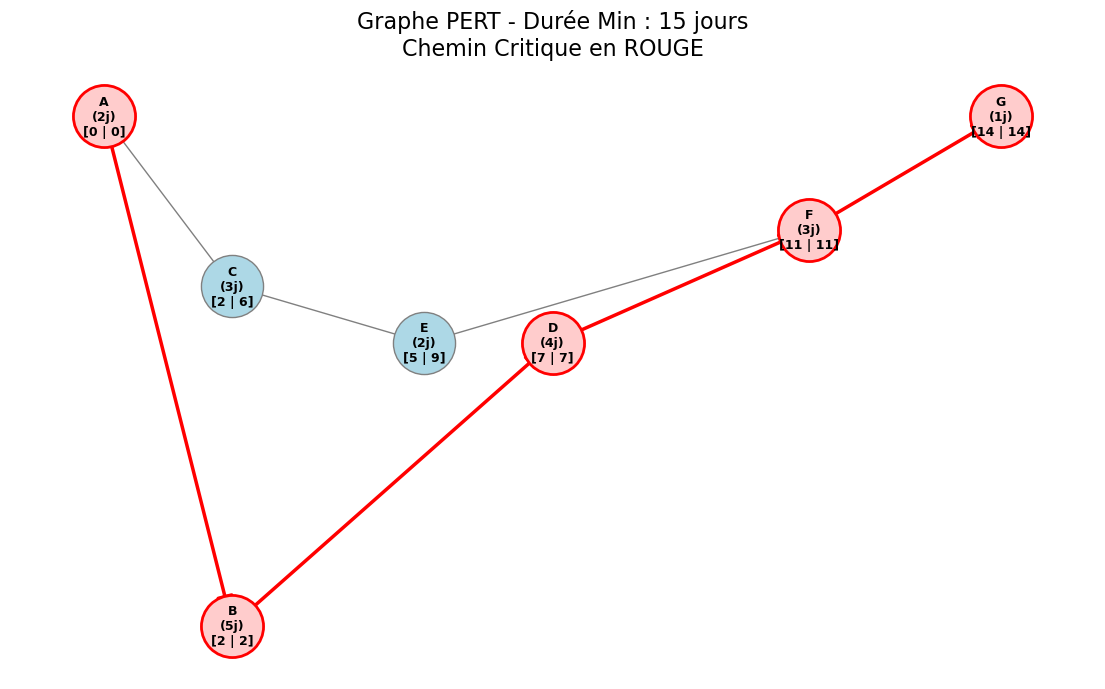

In [16]:

def visualiser_pert(pert_manager):
    plt.figure(figsize=(14, 8))
    
    # Positionnement hiérarchique (simulé via layout multipartite ou dot)
    # Ici on utilise un spring layout guidé par les dates au plus tôt (axe X)
    pos = {}
    for tache, date in pert_manager.dates_tot.items():
        # X = Date au plus tôt, Y = Hash du nom pour disperser
        pos[tache] = (date, hash(tache) % 10)
    
    # Ajustement pour lisibilité
    pos = nx.spring_layout(pert_manager.G, pos=pos, fixed=pos.keys(), k=5, iterations=50)

    # 1. Dessin des tâches non critiques (Bleu)
    non_critiques = [n for n in pert_manager.G.nodes if n not in pert_manager.chemin_critique]
    nx.draw_networkx_nodes(pert_manager.G, pos, nodelist=non_critiques, node_color='lightblue', node_size=2000, edgecolors='grey')
    
    # 2. Dessin des tâches critiques (Rouge)
    nx.draw_networkx_nodes(pert_manager.G, pos, nodelist=pert_manager.chemin_critique, node_color='#ffcccc', edgecolors='red', linewidths=2, node_size=2000)
    
    # 3. Arêtes (Dépendances)
    # Arêtes critiques
    edges_critiques = []
    edges_non_critiques = []
    
    # Identification des arêtes critiques (relient deux tâches critiques consécutives)
    for u, v in pert_manager.G.edges():
        if u in pert_manager.chemin_critique and v in pert_manager.chemin_critique:
            # Vérification stricte : est-ce que v suit immédiatement u temporellement ?
            if pert_manager.dates_tot[u] + pert_manager.taches[u]['duree'] == pert_manager.dates_tot[v]:
                edges_critiques.append((u, v))
            else:
                edges_non_critiques.append((u, v))
        else:
            edges_non_critiques.append((u, v))

    nx.draw_networkx_edges(pert_manager.G, pos, edgelist=edges_non_critiques, edge_color='grey', arrows=True, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edges(pert_manager.G, pos, edgelist=edges_critiques, edge_color='red', width=2.5, arrows=True, arrowstyle='-|>', arrowsize=25)

    # 4. Labels (Nom + Dates)
    labels = {}
    for n in pert_manager.G.nodes():
        tto = pert_manager.dates_tot[n]
        tta = pert_manager.dates_tard[n]
        duree = pert_manager.taches[n]['duree']
        labels[n] = f"{n}\n({duree}j)\n[{tto} | {tta}]"
        
    nx.draw_networkx_labels(pert_manager.G, pos, labels=labels, font_size=9, font_weight='bold')
    
    plt.title(f"Graphe PERT - Durée Min : {pert_manager.duree_totale} jours\nChemin Critique en ROUGE", fontsize=16)
    plt.axis('off')
    plt.show()

visualiser_pert(pert)

### FONCTION DIAGRAMME DE GANTT


In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualiser_gantt(pert_manager):
    """
    Génère un diagramme de Gantt à partir de l'objet PERTManager.
    Axe X : Temps (Jours)
    Axe Y : Tâches
    Couleur : Rouge (Critique) / Bleu (Non critique)
    """
    # 1. Préparation des données
    taches = list(pert_manager.taches.keys())
    
    # On inverse l'ordre pour avoir la tâche A en haut du graphique
    taches.reverse()
    
    start_dates = [pert_manager.dates_tot[t] for t in taches]
    durations = [pert_manager.taches[t]['duree'] for t in taches]
    
    # Détermination des couleurs
    colors = []
    for t in taches:
        if t in pert_manager.chemin_critique:
            colors.append('#E74C3C') # Rouge (Critique)
        else:
            colors.append('#3498DB') # Bleu (Marge)

    # 2. Création du graphique
    plt.figure(figsize=(12, 6))
    
    # Création des barres (left = date de début, width = durée)
    bars = plt.barh(taches, durations, left=start_dates, color=colors, edgecolor='black', height=0.6, alpha=0.9)
    
    # 3. Mise en forme
    plt.title("Planning de Réalisation (Diagramme de GANTT)", fontsize=14, pad=20)
    plt.xlabel("Jours depuis le début du projet", fontsize=12)
    plt.ylabel("Tâches", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Ajout des étiquettes de durée dans/à côté des barres
    for bar, duration in zip(bars, durations):
        if duration > 0: # Évite d'écrire sur des tâches de durée 0
            width = bar.get_width()
            plt.text(bar.get_x() + width/2, 
                     bar.get_y() + bar.get_height()/2, 
                     f"{int(width)}j", 
                     ha='center', va='center', color='white', fontweight='bold', fontsize=9)

    # 4. Légende Manuelle
    red_patch = mpatches.Patch(color='#E74C3C', label='Tâche Critique (0 marge)')
    blue_patch = mpatches.Patch(color='#3498DB', label='Tâche avec Marge')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()

print("Fonction 'visualiser_gantt' chargée.")

Fonction 'visualiser_gantt' chargée.


## VI - Interface graphique

In [19]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Nécessaire pour la légende du Gantt
import pandas as pd
import time
import numpy as np # Nécessaire pour le calcul de moyenne (Floyd-Warshall)

# --- 1. FONCTION SPÉCIFIQUE POUR LE GANTT ---
def generer_gantt(pert_manager):
    """
    Génère un diagramme de Gantt basé sur les dates au plus tôt.
    Rouge = Chemin Critique, Bleu = Tâches avec marge.
    """
    plt.figure(figsize=(10, 6))
    
    # Récupération des données
    # On inverse l'ordre pour avoir la tâche A en haut du graphique (Axe Y)
    taches = list(pert_manager.taches.keys())[::-1]
    
    start_dates = [pert_manager.dates_tot[t] for t in taches]
    durations = [pert_manager.taches[t]['duree'] for t in taches]
    
    # Détermination des couleurs (Critique vs Marge)
    colors = []
    for t in taches:
        if t in pert_manager.chemin_critique:
            colors.append('#e74c3c') # Rouge
        else:
            colors.append('#3498db') # Bleu

    # Création des barres
    bars = plt.barh(taches, durations, left=start_dates, color=colors, edgecolor='black', height=0.6, alpha=0.9)
    
    # Ajout de la durée textuelle au centre des barres
    for bar, duration in zip(bars, durations):
        if duration > 0:
            width = bar.get_width()
            plt.text(bar.get_x() + width/2, 
                     bar.get_y() + bar.get_height()/2, 
                     f"{int(duration)}j", 
                     ha='center', va='center', color='white', fontweight='bold', fontsize=9)

    # Légende et Labels
    plt.title("Planning de Réalisation (Diagramme de GANTT)", fontsize=14, pad=15)
    plt.xlabel("Jours depuis le début du projet", fontsize=11)
    plt.ylabel("Tâches", fontsize=11)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Légende personnalisée
    legend_patches = [
        mpatches.Patch(color='#e74c3c', label='Tâche Critique (Marge=0)'),
        mpatches.Patch(color='#3498db', label='Tâche avec Marge')
    ]
    plt.legend(handles=legend_patches, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# --- 2. INTERFACE MISE À JOUR ---
def lancer_interface_finale(G_base, pert_manager):
    """
    Interface graphique unique pour le projet ALMF51.
    Centralise toutes les visualisations et les résultats textuels.
    """
    
    # =========================================================================
    # 1. DESIGN & WIDGETS
    # =========================================================================
    
    # --- En-tête (Welcome & Mode d'emploi) ---
    header_html = widgets.HTML(
        value="""
        <div style="background-color: #f7f9fa; padding: 20px; border-radius: 8px; border-left: 5px solid #2c3e50; margin-bottom: 20px;">
            <h2 style="color: #2c3e50; margin: 0;">PROJET ALGORITHMIQUE DES GRAPHES </h2>
            <p style="color: #7f8c8d; font-size: 14px; margin-top: 5px;">
                Interface de démonstration centralisée.
            </p>
            <hr style="border: 0; border-top: 1px solid #e1e8ed;">
            <p style="font-size: 13px; color: #34495e;">
                <b>MODE D'EMPLOI :</b><br>
                1. Sélectionnez un <b>Algorithme</b> dans le menu déroulant.<br>
                2. (Optionnel) Choisissez une ville de <b>Départ</b> et d'<b>Arrivée</b>.<br>
                3. Cliquez sur <b>"LANCER LA DÉMONSTRATION"</b> pour voir les résultats.
            </p>
        </div>
        """
    )
    
    # --- Sélecteurs ---
    liste_algos = [
        '--- SÉLECTIONNER UN MODULE ---',
        '1. Parcours en Largeur (BFS)', 
        '2. Parcours en Profondeur (DFS)', 
        '3. Plus Court Chemin (Dijkstra)', 
        '4. Poids Négatifs (Bellman-Ford)', 
        '5. Arbre Couvrant (Prim)', 
        '6. Arbre Couvrant (Kruskal)',
        '7. Matrice & Centralité (Floyd-Warshall)',
        '8. Gestion de Projet (PERT)'
    ]
    
    villes = sorted(list(G_base.nodes()))
    
    # Layouts pour alignement
    layout_full = widgets.Layout(width='98%')
    layout_half = widgets.Layout(width='48%')
    
    dd_algo = widgets.Dropdown(options=liste_algos, description='Algorithme :', style={'description_width': 'initial'}, layout=layout_full)
    dd_depart = widgets.Dropdown(options=villes, value='Rennes', description=' Départ :', style={'description_width': 'initial'}, layout=layout_half)
    dd_arrivee = widgets.Dropdown(options=villes, value='Marseille', description=' Arrivée :', style={'description_width': 'initial'}, layout=layout_half)
    
    # Bouton d'action
    btn_run = widgets.Button(
        description='LANCER LA DÉMONSTRATION',
        button_style='primary', # Bleu
        icon='play',
        layout=widgets.Layout(width='100%', height='50px', margin='15px 0')
    )
    
    # --- Zones d'Affichage (Outputs) ---
    # Onglet 1 : Graphique / Matrice
    out_visu = widgets.Output(layout=widgets.Layout(height='650px', border='1px solid #ddd', overflow_y='auto', padding='10px'))
    # Onglet 2 : Journal / Logs
    out_logs = widgets.Output(layout=widgets.Layout(height='650px', border='1px solid #ddd', overflow_y='auto', padding='10px', background_color='#fafafa'))
    
    tabs = widgets.Tab(children=[out_visu, out_logs])
    tabs.set_title(0, 'VISUALISATION GRAPHIQUE')
    tabs.set_title(1, 'JOURNAL DES ATTENDUS & RÉSULTATS')

    # =========================================================================
    # 2. LOGIQUE D'AFFICHAGE (HANDLERS)
    # =========================================================================
    
    def log_html(titre, contenu, couleur="#34495e"):
        """Helper pour afficher des logs formatés."""
        display(widgets.HTML(f"""
            <div style="margin-bottom: 15px; border-left: 4px solid {couleur}; padding-left: 10px;">
                <h4 style="margin: 0; color: {couleur}; text-transform: uppercase;">{titre}</h4>
                <div style="font-family: monospace; font-size: 13px; margin-top: 5px;">{contenu}</div>
            </div>
        """))

    def on_run_click(b):
        algo = dd_algo.value
        src = dd_depart.value
        dst = dd_arrivee.value
        
        # 1. Nettoyage complet
        out_visu.clear_output()
        out_logs.clear_output()
        
        # 2. Vérification sélection
        if algo == liste_algos[0]:
            with out_visu:
                # Retour à la vue par défaut
                dessiner_graphe(G_base)
            with out_logs:
                log_html("Info", "Veuillez sélectionner un algorithme pour commencer.", "orange")
            return

        start_time = time.time()
        
        try:
            # --- PARCOURS BFS ---
            if 'BFS' in algo:
                edges, nodes = parcours_largeur(G_base, src)
                with out_visu:
                    draw_graph_clean(G_base, highlight_edges=edges, highlight_nodes=nodes, 
                                     title=f"Exploration BFS depuis {src}", color_code='#3498DB')
                with out_logs:
                    log_html("Statistiques", f"Temps d'exécution : {time.time()-start_time:.4f}s")
                    log_html("Ordre de Visite", " -> ".join(nodes), "#3498DB")
                    log_html("Couverture", f"{len(nodes)} villes visitées sur {len(G_base.nodes())}")

            # --- PARCOURS DFS ---
            elif 'DFS' in algo:
                edges, nodes = parcours_profondeur(G_base, src)
                with out_visu:
                    draw_graph_clean(G_base, highlight_edges=edges, highlight_nodes=nodes, 
                                     title=f"Exploration DFS depuis {src}", color_code='#2980B9')
                with out_logs:
                    log_html("Statistiques", f"Temps d'exécution : {time.time()-start_time:.4f}s")
                    log_html("Ordre de Visite", " -> ".join(nodes), "#2980B9")

            # --- DIJKSTRA ---
            elif 'Dijkstra' in algo:
                path, dist = dijkstra(G_base, src, dst)
                if dist != float('inf'):
                    edges = list(zip(path, path[1:]))
                    with out_visu:
                        draw_graph_clean(G_base, highlight_edges=edges, highlight_nodes=path, 
                                         title=f"Dijkstra : {src} ➝ {dst}", color_code='#E67E22')
                    with out_logs:
                        log_html("Résultat", " Chemin optimal trouvé !", "green")
                        log_html("Distance Totale", f"<b>{dist} km</b>", "#E67E22")
                        log_html("Itinéraire Détaillé", " -> ".join(path))
                else:
                    with out_visu: draw_graph_clean(G_base, title="Aucun chemin trouvé", color_code='grey')
                    with out_logs: log_html("Erreur", "Pas de chemin possible.", "red")

            # --- BELLMAN-FORD (Poids Négatifs) ---
            elif 'Bellman-Ford' in algo:
                G_temp = G_base.to_directed()
                updates = [("Rennes", "Nantes", -2), ("Lyon", "Marseille", -5)]
                for u, v, w in updates:
                    if G_temp.has_edge(u, v): G_temp[u][v]['weight'] = w
                
                dist, preds, has_cycle = bellman_ford_path(G_temp, src)
                
                if has_cycle:
                    with out_visu: draw_graph_clean(G_temp, title="CYCLE NÉGATIF DÉTECTÉ", color_code='purple')
                    with out_logs: log_html("Alerte", "Cycle négatif détecté ! Calcul interrompu.", "purple")
                else:
                    path = reconstruire_chemin(preds, src, dst)
                    if path:
                        edges = list(zip(path, path[1:]))
                        with out_visu:
                            draw_graph_clean(G_temp, highlight_edges=edges, highlight_nodes=path, 
                                             title=f"Bellman-Ford : {src} ➝ {dst}", color_code='#8E44AD')
                        with out_logs:
                            log_html("Scénario", "Injection de poids négatifs (Rennes->Nantes: -2, Lyon->Marseille: -5)", "grey")
                            log_html("Distance Optimale", f"<b>{dist[dst]} km</b>", "#8E44AD")
                            log_html("Itinéraire", " -> ".join(path))
                    else:
                        with out_logs: log_html("Info", "Pas de chemin.", "red")

            # --- ARBRES COUVRANTS (PRIM/KRUSKAL) ---
            elif 'Arbre Couvrant' in algo:
                if 'Prim' in algo:
                    mst, poids = prim(G_base, src)
                    titre, color = f"ACPM (Prim) depuis {src}", "#27AE60"
                else:
                    mst, poids = kruskal(G_base)
                    titre, color = "ACPM (Kruskal)", "#16A085"
                
                with out_visu:
                    draw_graph_clean(G_base, highlight_edges=list(mst.edges()), highlight_nodes=list(mst.nodes()), 
                                     title=f"{titre} - Poids : {poids} km", color_code=color)
                with out_logs:
                    log_html("Performance", f"Poids Total de l'Arbre : <b>{poids} km</b>", color)
                    log_html("Structure", f"Nombre d'arêtes : {mst.number_of_edges()}")
                    edges_list = "<br>".join([f"{u} ↔ {v} ({d['weight']} km)" for u,v,d in mst.edges(data=True)])
                    log_html("Liste des Arêtes Sélectionnées", edges_list)

            # --- FLOYD-WARSHALL & CENTRALITÉ ---
            elif 'Floyd-Warshall' in algo:
                matrice = floyd_warshall(G_base)
                
                # --- CALCUL DE CENTRALITÉ (NOUVEAU) ---
                # On remplace les infinis par NaN pour éviter de fausser la moyenne (si graphe non connexe)
                # Mais ici le graphe est connexe.
                df_calc = matrice.replace(float('inf'), np.nan)
                
                # Moyenne par ville (ligne)
                # On divise par (N-1) pour avoir la moyenne vers les *autres* villes (la distance vers soi-même est 0)
                # mean() de pandas le fait automatiquement en ignorant NaN
                moyennes = df_calc.mean(axis=1)
                
                # Ville avec la moyenne la plus faible
                ville_centrale = moyennes.idxmin()
                score_central = moyennes.min()
                
                with out_visu:
                    display(widgets.HTML(f"<h3 style='text-align:center; color:#2c3e50;'>Matrice des Distances (Heatmap)</h3>"))
                    display(matrice.style.background_gradient(cmap='coolwarm', axis=None).format("{:.0f}"))
                
                with out_logs:
                    # 1. Analyse de Centralité (AJOUT DEMANDÉ)
                    display(widgets.HTML("<h4 style='color:#C0392B; border-bottom:2px solid #C0392B; padding-bottom:5px;'>--- ANALYSE DE CENTRALITÉ DU RÉSEAU ---</h4>"))
                    
                    log_html("Centre de Gravité", f"La ville la plus centrale est : <b>{ville_centrale.upper()}</b>", "#C0392B")
                    
                    explication = f"La ville de <b>{ville_centrale}</b> est le centre de gravité du réseau car elle possède la distance moyenne la plus courte vers toutes les autres destinations (<b>{score_central:.2f} km</b>)."
                    log_html("Explication", explication, "#7F8C8D")
                    
                    # Petit bonus : Top 3
                    top3 = moyennes.sort_values().head(3)
                    top3_html = "<ul>" + "".join([f"<li>{v} : {s:.1f} km</li>" for v, s in top3.items()]) + "</ul>"
                    log_html("Top 3 des villes les mieux connectées", top3_html, "gray")

            # --- PERT & GANTT ---
            elif 'PERT' in algo:
                with out_visu:
                    # 1. Graphe PERT
                    visualiser_pert(pert_manager)
                    
                    # Séparateur visuel
                    display(widgets.HTML("<hr style='border-top: 2px dashed #ccc; margin: 30px 0;'>"))
                    
                    # 2. Diagramme de GANTT
                    generer_gantt(pert_manager)
                    
                with out_logs:
                    # 1. NOM DU PROJET
                    log_html("PROJET", "<b>INSTALLATION DE BORNES DE RECHARGE ÉLECTRIQUES</b>", "#2C3E50")
                    
                    # 2. INVENTAIRE DES TÂCHES
                    inventory_html = "<ul>"
                    for t_id, t_info in pert_manager.taches.items():
                        desc = t_info.get('desc', 'Pas de description')
                        duree = t_info['duree']
                        inventory_html += f"<li><b>Tâche {t_id} :</b> {desc} ({duree} jours)</li>"
                    inventory_html += "</ul>"
                    log_html("Inventaire des Tâches", inventory_html, "#7F8C8D")
                    
                    # 3. RÉSULTATS D'OPTIMISATION
                    log_html("Synthèse Projet", f"Durée Minimale : <b>{pert_manager.duree_totale} jours</b>", "#E74C3C")
                    log_html("Chemin Critique", " -> ".join(pert_manager.chemin_critique), "red")
                    
                    data = {
                        "Durée": [pert_manager.taches[t]['duree'] for t in pert_manager.taches],
                        "Début Tôt": [pert_manager.dates_tot[t] for t in pert_manager.taches],
                        "Début Tard": [pert_manager.dates_tard[t] for t in pert_manager.taches],
                        "Marge Totale": [pert_manager.marges[t] for t in pert_manager.taches],
                        "Statut": ["CRITIQUE " if m==0 else "Normal" for m in pert_manager.marges.values()]
                    }
                    df = pd.DataFrame(data, index=pert_manager.taches.keys())
                    display(widgets.HTML("<b>Tableau des Marges :</b>"))
                    display(df)

        except Exception as e:
            with out_logs: log_html("ERREUR CRITIQUE", str(e), "red")

    btn_run.on_click(on_run_click)

    # =========================================================================
    # 3. MISE EN PAGE FINALE
    # =========================================================================
    
    controls = widgets.HBox([dd_algo, dd_depart, dd_arrivee], layout=widgets.Layout(margin='0 0 10px 0'))
    ui = widgets.VBox([header_html, controls, btn_run, tabs])
    
    display(ui)
    
    # Init
    with out_visu: dessiner_graphe(G_base)
    with out_logs: log_html("Système Prêt", "Sélectionnez un module pour démarrer.", "green")

# --- LANCEMENT DE L'INTERFACE FINALE ---
if 'G_projet' in locals() and 'pert' in locals():
    lancer_interface_finale(G_projet, pert)
else:
    print(" ERREUR : Veuillez exécuter les cellules précédentes pour charger 'G_projet' et 'pert'.")
    